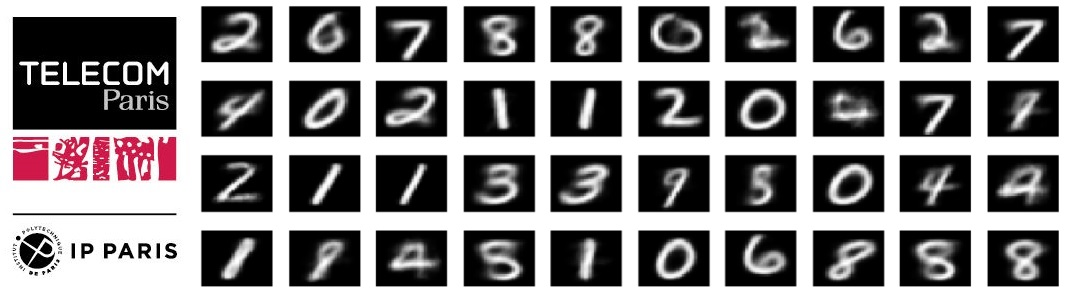
**TP - Variational auto-Encoders (VAE)**
---
BGDIA704 - Machine Learing avancé, Stéphane LATHUILIERE<br><br>
**Anaële BAUDANT-COJAN**<br>
Master spécialisé IA 2023-2024, Telecom Paris-ENSTA<br>
Palaiseau, le 18 mars 2024

# Training a VAE on MNIST
Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

    Navigate to Edit→Notebook Settings
    select GPU from the Hardware Accelerator drop-down
    
You can check if the GPU works with nvidia-smi.


## Data loading
Let's import some libraries and load the MNIST dataset.

In [2]:

# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import IPython.display
import numpy as np

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)








## Architecture specification

You can use the following encoder (don't forget that in a VAE the decoder has two heads, for the mean and the variance):
```
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
```
and this decoder:
```
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
```
Then, you need to complete the forward function. You can use Relu activations for every layers except for the heads that can reach negative values. Concerning the decoder head, you can use sigmoid to obtain values in [0,1].

Here we consider a latent space of dimension 2 but is could be any *zdim* dimension.

In [3]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part (pas possible de faire du sequentiel)
        self.fc1 = torch.nn.Linear(in_features = x_dim, out_features = h_dim1)
        self.fc2 = torch.nn.Linear(in_features = h_dim1, out_features = h_dim2)
        self.fc31 = torch.nn.Linear(in_features = h_dim2, out_features = 2) # on veut Z avec 2 dimension pour visualiser
        self.fc32 = torch.nn.Linear(in_features = h_dim2, out_features = 2)

        # decoder part
        self.fc4 = torch.nn.Linear(in_features = 2, out_features = h_dim2)
        self.fc5 = torch.nn.Linear(in_features = h_dim2 , out_features = h_dim1)
        self.fc6 = torch.nn.Linear(in_features = h_dim1, out_features = x_dim)

    def encoder(self, x):
        output1 = torch.relu(self.fc1(x))
        output2 =  torch.relu(self.fc2(output1))
        output31 = self.fc31 (output2)
        output32 =  self.fc32 (output2)
        return output31, output32

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var) # le 0.5 correspond à la racine de sigma
        eps = torch.randn_like(std) # std is used only for its dimensions
        return mu + std * eps

    def decoder(self, z):
        output4 = torch.relu(self.fc4 (z))
        output5 =  torch.relu(self.fc5 (output4))
        output6 = torch.sigmoid(self.fc6 (output5)) # entre [0,1] pour donner proba à la binary cross entropy
        return output6

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        image_rec= self.decoder(z)
        return image_rec, mu, log_var


## Loss function
The total loss of the VAE is composed of two terms: a reconstruction term and the KL divergence with the Prior. The KL divergence between two gaussians is given by:

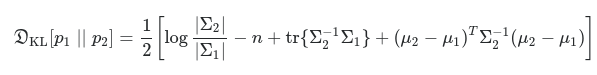

Assuming a unit gaussian as prior, we obtain a very simple equation that will help you to implement it in pytorch:

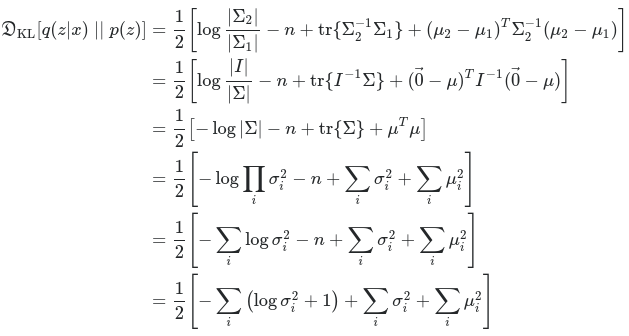

Note that, in these equations sigma denotes the standard deviation while the encoder network ouputs the log of the variance.  

In [4]:
# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()
optimizer = optim.Adam(vae.parameters())

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    mse_loss = nn.MSELoss(reduction='sum')
    RecLoss = mse_loss(recon_x, x)
    KLDLoss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return torch.sum(RecLoss + KLDLoss)


## Training step
In this cell, we define the function that performs training on one epoch. We recommend to debug it using the "main loop" cell later in the page.

In [10]:
def train(epoch):
    vae.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):

        if torch.cuda.is_available(): data = data.cuda() # fonctionnera si pas CPU
        data = data.view(100, -1) ## besoin de redimensionner data car data.size() =torch.Size([100, 1, 28, 28]) 100=batch size, 1= channel dim image 28x28
        optimizer.zero_grad()

        recon_data, mu, log_var = vae.forward(data)
        loss = loss_function(recon_data, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        vae_batch_Losses.append(loss.item())
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))

    # average and store loss once batches of the epoch are finished
    average_loss = train_loss / len(train_loader.dataset)
    train_Losses.append(average_loss)

    # show epoch loss and update Loss graph
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


## Visualization:
We provide some visualization functions:

In [26]:

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(5, 5))
    plt.plot(train_Losses, label='Train losses')
    plt.plot(test_Losses, label='Test losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)
    plt.show()

# Create a wall of generated MNIST images
def plotGeneratedImages(generatedImages,dim=(4, 10), figsize=(8, 3.6)):
    generatedImages=generatedImages.cpu().numpy()
    print('generated images shape',generatedImages.shape)
    print('displaying first 40 images')
    plt.figure(figsize=figsize)
    for i in range(40): #range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(np.squeeze(generatedImages[i]), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    plt.show()
    #IPython.display.display(IPython.display.Image(data=('gan_generated_image_epoch_%d.png' % epoch)))


## Test
Complete the test function that generate new sample from latent space samples.

In [24]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            if torch.cuda.is_available(): data = data.cuda() # fonctionnera si pas CPU
            data = data.view(data.size(0), -1) # redimensionne en vecteur de taille 784 (28x28 pixels)
            recon, mu, log_var = vae.forward(data)

            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
            #loss_function(recon_x, x, mu, log_var):

    test_loss /= len(test_loader.dataset)
    test_Losses.append(test_loss)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    with torch.no_grad():
      z = torch.randn(64, 2)
      if torch.cuda.is_available(): z = z.cuda() # fonctionnera si pas CPU.cuda()
      generated = vae.decoder(z)
      plotGeneratedImages(generated.view(generated.size(0), 1, 28, 28)) #generated.size(0)
      #save_image(sample.view(64, 1, 28, 28), '.sample_' + '.png')



## Main loop

Train Epoch: 1 [0/60000 (0%)]	Loss: 34.148665
Train Epoch: 1 [10000/60000 (17%)]	Loss: 34.505088
Train Epoch: 1 [20000/60000 (33%)]	Loss: 33.354548
Train Epoch: 1 [30000/60000 (50%)]	Loss: 33.718767
Train Epoch: 1 [40000/60000 (67%)]	Loss: 31.148325
Train Epoch: 1 [50000/60000 (83%)]	Loss: 32.820449
====> Epoch: 1 Average loss: 33.3824
====> Test set loss: 34.0139
generated images shape (64, 1, 28, 28)
displaying first 40 images


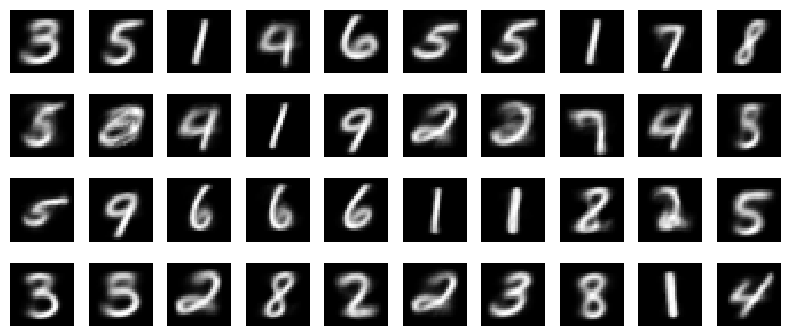

Train Epoch: 2 [0/60000 (0%)]	Loss: 34.160747
Train Epoch: 2 [10000/60000 (17%)]	Loss: 34.513408
Train Epoch: 2 [20000/60000 (33%)]	Loss: 34.011401
Train Epoch: 2 [30000/60000 (50%)]	Loss: 34.492881
Train Epoch: 2 [40000/60000 (67%)]	Loss: 33.848813
Train Epoch: 2 [50000/60000 (83%)]	Loss: 32.372881
====> Epoch: 2 Average loss: 33.3997
====> Test set loss: 33.8300
generated images shape (64, 1, 28, 28)
displaying first 40 images


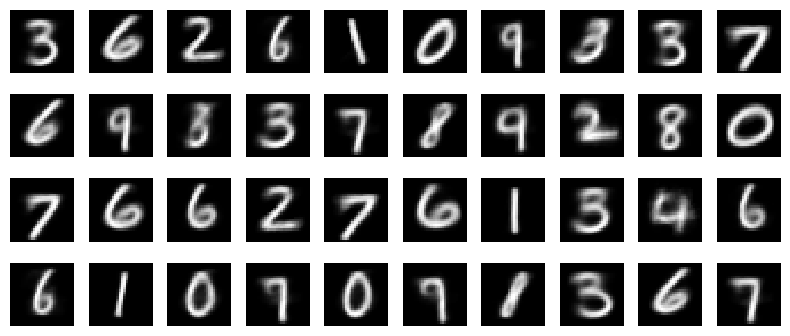

Train Epoch: 3 [0/60000 (0%)]	Loss: 33.032915
Train Epoch: 3 [10000/60000 (17%)]	Loss: 32.994187
Train Epoch: 3 [20000/60000 (33%)]	Loss: 34.206743
Train Epoch: 3 [30000/60000 (50%)]	Loss: 34.734399
Train Epoch: 3 [40000/60000 (67%)]	Loss: 33.299395
Train Epoch: 3 [50000/60000 (83%)]	Loss: 32.211895
====> Epoch: 3 Average loss: 33.3854
====> Test set loss: 34.0155
generated images shape (64, 1, 28, 28)
displaying first 40 images


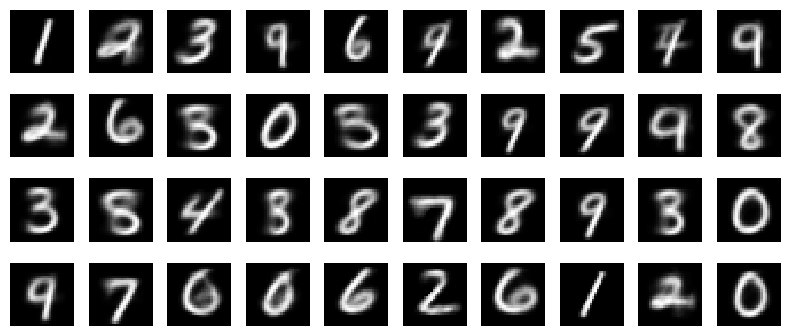

Train Epoch: 4 [0/60000 (0%)]	Loss: 33.231616
Train Epoch: 4 [10000/60000 (17%)]	Loss: 33.904084
Train Epoch: 4 [20000/60000 (33%)]	Loss: 33.977578
Train Epoch: 4 [30000/60000 (50%)]	Loss: 34.840107
Train Epoch: 4 [40000/60000 (67%)]	Loss: 32.858511
Train Epoch: 4 [50000/60000 (83%)]	Loss: 31.844590
====> Epoch: 4 Average loss: 33.3478
====> Test set loss: 33.9156
generated images shape (64, 1, 28, 28)
displaying first 40 images


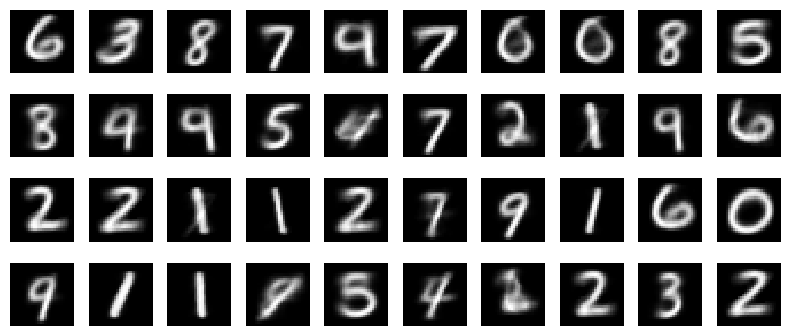

Train Epoch: 5 [0/60000 (0%)]	Loss: 35.041624
Train Epoch: 5 [10000/60000 (17%)]	Loss: 34.928572
Train Epoch: 5 [20000/60000 (33%)]	Loss: 32.549199
Train Epoch: 5 [30000/60000 (50%)]	Loss: 34.133274
Train Epoch: 5 [40000/60000 (67%)]	Loss: 33.992878
Train Epoch: 5 [50000/60000 (83%)]	Loss: 34.415579
====> Epoch: 5 Average loss: 33.3235
====> Test set loss: 33.9291
generated images shape (64, 1, 28, 28)
displaying first 40 images


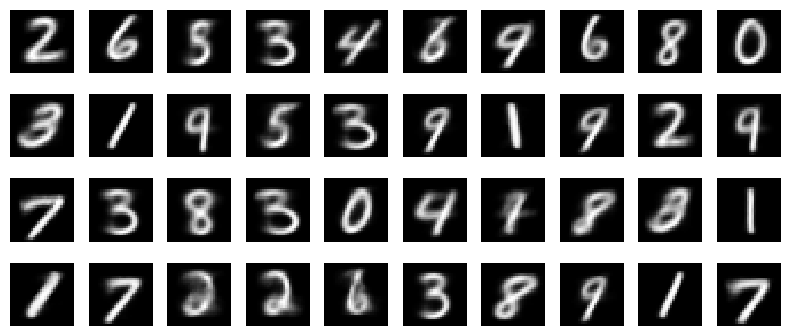

Train Epoch: 6 [0/60000 (0%)]	Loss: 32.211379
Train Epoch: 6 [10000/60000 (17%)]	Loss: 32.436113
Train Epoch: 6 [20000/60000 (33%)]	Loss: 33.786360
Train Epoch: 6 [30000/60000 (50%)]	Loss: 33.568750
Train Epoch: 6 [40000/60000 (67%)]	Loss: 34.128750
Train Epoch: 6 [50000/60000 (83%)]	Loss: 33.113052
====> Epoch: 6 Average loss: 33.2811
====> Test set loss: 33.8619
generated images shape (64, 1, 28, 28)
displaying first 40 images


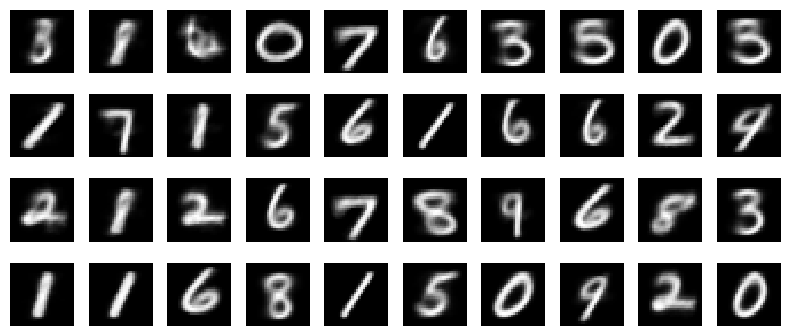

Train Epoch: 7 [0/60000 (0%)]	Loss: 34.087734
Train Epoch: 7 [10000/60000 (17%)]	Loss: 35.339419
Train Epoch: 7 [20000/60000 (33%)]	Loss: 31.213569
Train Epoch: 7 [30000/60000 (50%)]	Loss: 34.608638
Train Epoch: 7 [40000/60000 (67%)]	Loss: 32.554580
Train Epoch: 7 [50000/60000 (83%)]	Loss: 32.124712
====> Epoch: 7 Average loss: 33.2173
====> Test set loss: 33.8615
generated images shape (64, 1, 28, 28)
displaying first 40 images


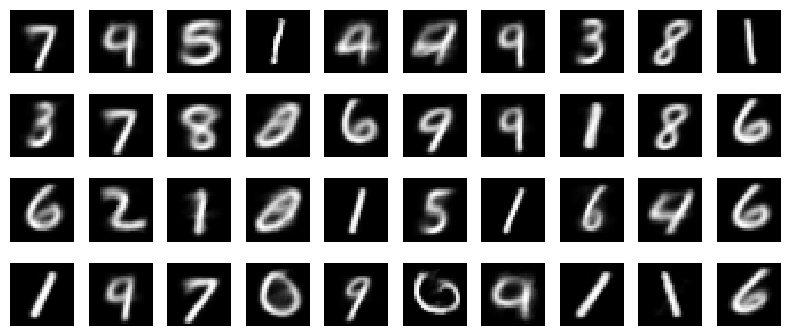

Train Epoch: 8 [0/60000 (0%)]	Loss: 34.358184
Train Epoch: 8 [10000/60000 (17%)]	Loss: 31.650193
Train Epoch: 8 [20000/60000 (33%)]	Loss: 33.597720
Train Epoch: 8 [30000/60000 (50%)]	Loss: 34.225754
Train Epoch: 8 [40000/60000 (67%)]	Loss: 32.805815
Train Epoch: 8 [50000/60000 (83%)]	Loss: 30.156697
====> Epoch: 8 Average loss: 33.2653
====> Test set loss: 33.8590
generated images shape (64, 1, 28, 28)
displaying first 40 images


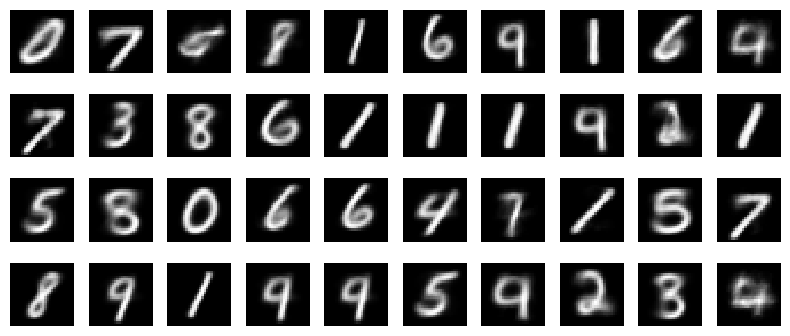

Train Epoch: 9 [0/60000 (0%)]	Loss: 33.009705
Train Epoch: 9 [10000/60000 (17%)]	Loss: 32.446978
Train Epoch: 9 [20000/60000 (33%)]	Loss: 33.780649
Train Epoch: 9 [30000/60000 (50%)]	Loss: 32.982119
Train Epoch: 9 [40000/60000 (67%)]	Loss: 34.677717
Train Epoch: 9 [50000/60000 (83%)]	Loss: 33.742397
====> Epoch: 9 Average loss: 33.2393
====> Test set loss: 33.8934
generated images shape (64, 1, 28, 28)
displaying first 40 images


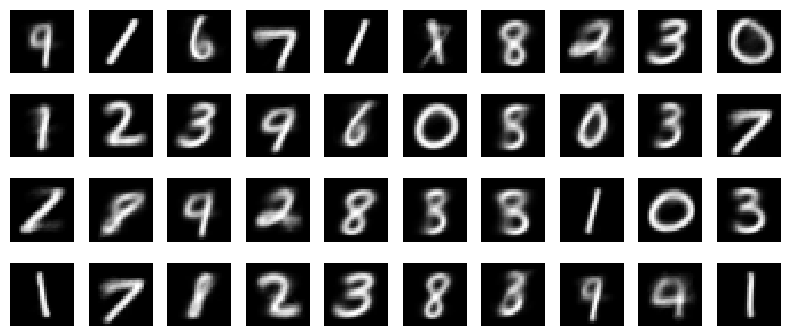

Train Epoch: 10 [0/60000 (0%)]	Loss: 34.169783
Train Epoch: 10 [10000/60000 (17%)]	Loss: 33.207144
Train Epoch: 10 [20000/60000 (33%)]	Loss: 34.600134
Train Epoch: 10 [30000/60000 (50%)]	Loss: 33.998042
Train Epoch: 10 [40000/60000 (67%)]	Loss: 34.403958
Train Epoch: 10 [50000/60000 (83%)]	Loss: 31.878999
====> Epoch: 10 Average loss: 33.2680
====> Test set loss: 33.8898
generated images shape (64, 1, 28, 28)
displaying first 40 images


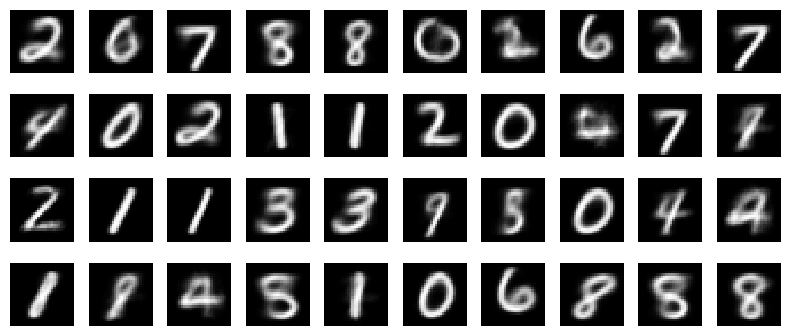

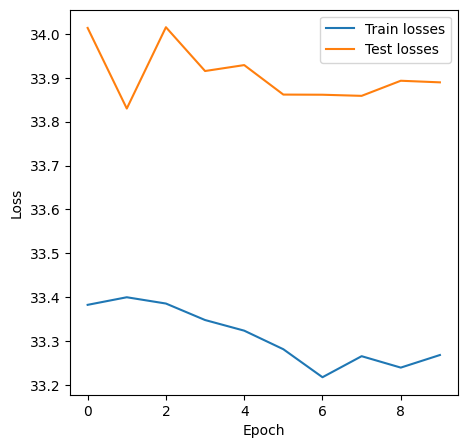

In [35]:
#Initialise vaeLosses to track the loss across epochs
train_Losses = []
test_Losses = []
vae_batch_Losses = []

# Main loop for epoch
n_epochs = 10

for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

#Plot the losses
plotLoss(n_epochs)


## Bonus 1: Interpolation
Sample two latent vectors z1 and z2 and generate the corresponding images. Then, generate 10 intermediate images by performing linear interpolation in the latent space between the z1 and z2.

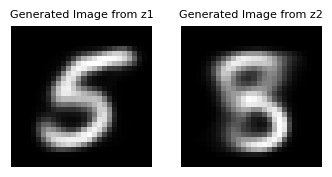

In [41]:
#sample 2 latent vectors z1 and z2
z_dim=2
z1 = torch.randn(1, z_dim)  # Randomly sample the first latent vector
z2 = torch.randn(1, z_dim)  # Randomly sample the second latent vector

# transfer Z& and z2 to gpu
z1 = z1.to("cuda" if torch.cuda.is_available() else "cpu")
z2 = z2.to("cuda" if torch.cuda.is_available() else "cpu")

# Generate the 2 images and plot
with torch.no_grad():  # No need to track gradients here
    generated_image1 = vae.decoder(z1).squeeze().cpu().numpy()
    generated_image2 = vae.decoder(z2).squeeze().cpu().numpy()

# reshape immages
generated_image1 = generated_image1.reshape(28, 28)
generated_image2 = generated_image2.reshape(28, 28)

# Show the 2 images generated
fig, axes = plt.subplots(1, 2, figsize=(4, 12))
axes[0].imshow(generated_image1, cmap='gray')
axes[0].set_title('Generated Image from z1',fontsize = 8)
axes[0].axis('off')

axes[1].imshow(generated_image2, cmap='gray')
axes[1].set_title('Generated Image from z2',fontsize = 8)
axes[1].axis('off')

plt.show()

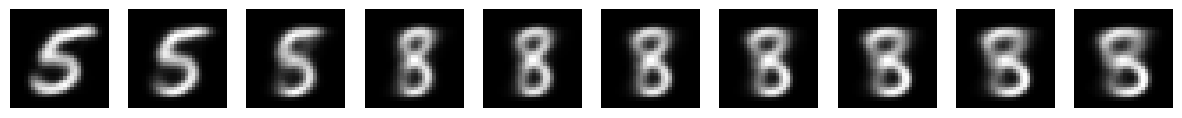

In [42]:
# INTERPOLATION

def interpolate(z1, z2, steps=10):
    z = [z1 + (z2 - z1) * t for t in torch.linspace(0, 1, steps)]
    return z

# Generate interpolated vectors
interpolated_z = interpolate(z1, z2)

# Generate images from interpolated vectors
with torch.no_grad():
    interpolated_images = [vae.decoder(z).view(28, 28).cpu().numpy() for z in interpolated_z]

# Plotting
fig, axes = plt.subplots(1, len(interpolated_images), figsize=(15, 15))
for ax, img in zip(axes, interpolated_images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

## Bonus 2: Visualization
Generate a 10x10 mosaic by sampling *z* over a regulargrid in [-1,1]x[-1,1]. What do you observe?


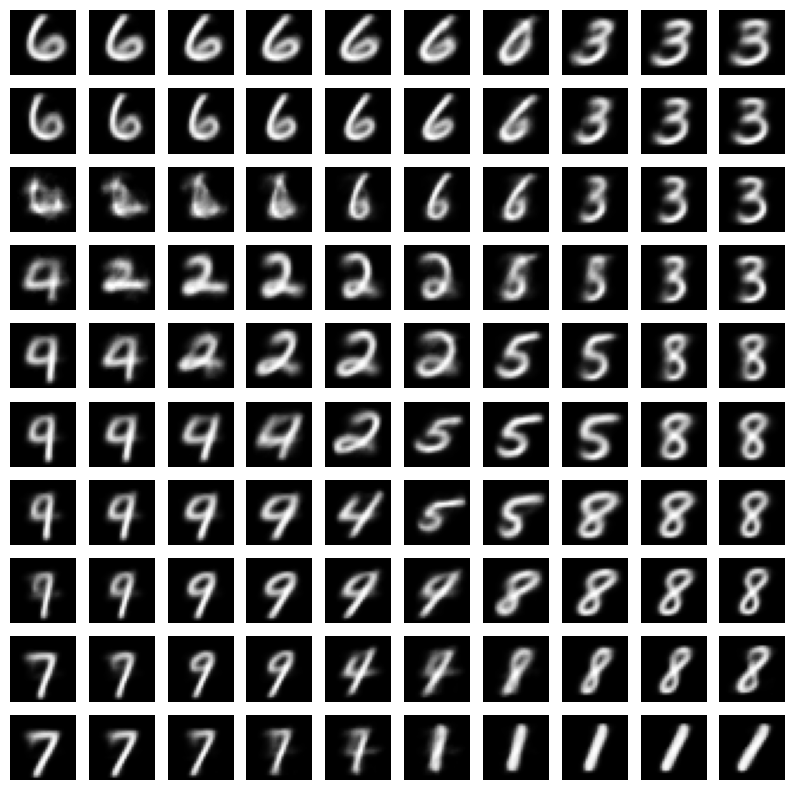

In [43]:
def generate_mosaic(vae, grid_size=10, z_dim=2, range_min=-1, range_max=1):
    # Assuming vae's decoder has parameters
    device = next(vae.parameters()).device

    # Create a grid of values in [-1, 1] x [-1, 1]
    grid_x = torch.linspace(range_min, range_max, grid_size, device=device)
    grid_y = torch.linspace(range_min, range_max, grid_size, device=device)
    grid_x, grid_y = torch.meshgrid(grid_x, grid_y, indexing='xy')
    z_grid = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

    # Generate images from the grid
    with torch.no_grad():
        interpolated_images = [vae.decoder(z).view(28, 28).cpu().numpy() for z in z_grid]

    # Plotting
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for ax, img in zip(axes.flatten(), interpolated_images):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.show()


generate_mosaic(vae)